# First, let's import a pre-trained model and prepare the data

In [1]:
import torch

In [2]:
trained_model_path = '../saved_models/SM0-0.pth.tar'

In [3]:
trained_model = torch.load(trained_model_path,map_location=torch.device('cpu'))

In [4]:
from SwinAgeMapper import SwinAgeMapper

In [5]:
model = SwinAgeMapper(
                    img_size = (160,192,160),
                    in_channels = 1,
                    depths = (2, 2, 2, 2),
                    num_heads = (3, 6, 12, 24),
                    feature_size = 24,
                    drop_rate = 0.0,
                    attn_drop_rate = 0.0,
                    dropout_path_rate = 0.0,
                    use_checkpoint = True,
                    spatial_dims = 3,
                    downsample = "merging",
                    fully_connected_activation = "relu",
                    resolution='1mm',
                    )

In [6]:
model.load_state_dict(trained_model)

<All keys matched successfully>

In [7]:
model.eval()

SwinAgeMapper(
  (Upsample): Identity()
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 24, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear

In [8]:
for key in model.state_dict().keys():
    print(key, '\n\t', model.state_dict()[key].shape)

swinViT.patch_embed.proj.weight 
	 torch.Size([24, 1, 2, 2, 2])
swinViT.patch_embed.proj.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm1.weight 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm1.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.attn.relative_position_bias_table 
	 torch.Size([2197, 3])
swinViT.layers1.0.blocks.0.attn.relative_position_index 
	 torch.Size([343, 343])
swinViT.layers1.0.blocks.0.attn.qkv.weight 
	 torch.Size([72, 24])
swinViT.layers1.0.blocks.0.attn.qkv.bias 
	 torch.Size([72])
swinViT.layers1.0.blocks.0.attn.proj.weight 
	 torch.Size([24, 24])
swinViT.layers1.0.blocks.0.attn.proj.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm2.weight 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.norm2.bias 
	 torch.Size([24])
swinViT.layers1.0.blocks.0.mlp.linear1.weight 
	 torch.Size([96, 24])
swinViT.layers1.0.blocks.0.mlp.linear1.bias 
	 torch.Size([96])
swinViT.layers1.0.blocks.0.mlp.linear2.weight 
	 torch.Size([24, 96])
swinViT.layers1.0.bl

In [9]:
import nibabel as nib
import numpy as np
import pandas as pd

In [10]:
# X_path = '../../multi-age-mapper/additional_data_examples/24237795/T1_brain_to_MNI.nii.gz'
# X2_path = '../../multi-age-mapper/additional_data_examples/24806531/T1_brain_to_MNI.nii.gz'
scaling_values = '../../../SwinAgeMapper/datasets/scaling_values_simple.csv'
# X_path = '24237795'
# X2_path = '24806531'
X_path = '24806531'

In [11]:
def processs_inputs(modality_flag='T1_nonlinear',
                    subject_path='24237795'
                   ):
    
    scaling_values_simple = pd.read_csv(scaling_values, index_col=0)
    scale_factor = scaling_values_simple.loc[modality_flag].scale_factor
    # resolution = scaling_values_simple.loc[list(modality_flag)].resolution.to_list()
    
    X_path = '../../multi-age-mapper/additional_data_examples/' + subject_path + '/T1_brain_to_MNI.nii.gz'
    X_volume = np.array(nib.load(X_path).dataobj)
    
    crop_values = [10, 170, 12, 204, 0, 160]
    
    X_volume = X_volume[crop_values[0]:crop_values[1],
                        crop_values[2]:crop_values[3], 
                        crop_values[4]:crop_values[5]]
    
    X_volume = X_volume / X_volume.mean()
    
    X_volume = X_volume / scale_factor
    X_volume = torch.from_numpy(X_volume)
    
    return X_volume

In [12]:
X = processs_inputs(subject_path = X_path)

In [13]:
X.shape

torch.Size([160, 192, 160])

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(-0.5, 191.5, 159.5, -0.5)

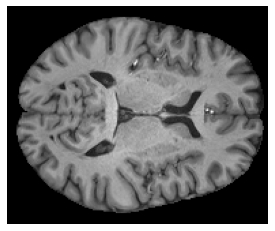

In [15]:
plt.imshow(X[:,:,80], cmap='gray')
plt.grid()
plt.axis('off')

In [16]:
from scipy import ndimage

(-0.5, 159.5, 191.5, -0.5)

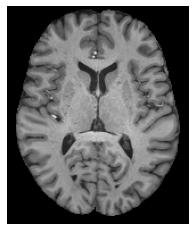

In [17]:
plt.imshow(ndimage.rotate(X[:,:,80], 90), cmap='gray')
plt.grid()
plt.axis('off')

In [18]:
Xviz = X.numpy().copy()
X = torch.unsqueeze(torch.unsqueeze(X, dim=0), dim=0)
X.shape

torch.Size([1, 1, 160, 192, 160])

In [19]:
model(X)

tensor([[67.7880]], grad_fn=<AddmmBackward0>)

In [20]:
y = model(X)

# Let's try to get some attention

In [21]:
head_fusion='max'
discard_ratio = 0.9

def rollout(attentions, discard_ratio, head_fusion):
    # result = torch.eye(attentions[0].size(-1))
    
    results = []
    
    with torch.no_grad():
        for attention in attentions:
            results.append(attention)
            
            print(attention.shape)
            
#             if head_fusion == "mean":
#                 attention_heads_fused = attention.mean(axis=1)
#             elif head_fusion == "max":
#                 attention_heads_fused = attention.max(axis=1)[0]
#             elif head_fusion == "min":
#                 attention_heads_fused = attention.min(axis=1)[0]
#             else:
#                 raise "Attention head fusion type Not supported"

#             # Drop the lowest attentions, but
#             # don't drop the class token
#             flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
#             _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
#             indices = indices[indices != 0]
#             flat[0, indices] = 0

#             I = torch.eye(attention_heads_fused.size(-1))
#             a = (attention_heads_fused + 1.0*I)/2
#             a = a / a.sum(dim=-1)

#             result = torch.matmul(a, result)
    
#     # Look at the total attention between the class token,
#     # and the image patches
#     mask = result[0, 0 , 1 :]
#     # In case of 224x224 image, this brings us from 196 to 14
#     width = int(mask.size(-1)**0.5)
#     mask = mask.reshape(width, width).numpy()
#     mask = mask / np.max(mask)
#     return mask   

    return results

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean", ###########  softmax, attn_drop
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():

            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [22]:
print("Doing Attention Rollout")
attention_rollout = VITAttentionRollout(model, head_fusion=head_fusion, 
    discard_ratio=discard_ratio)
mask = attention_rollout(X)
# name = "attention_rollout_{:.3f}_{}.png".format(discard_ratio, head_fusion)

Doing Attention Rollout


None of the inputs have requires_grad=True. Gradients will be None


torch.Size([2016, 3, 343, 343])
torch.Size([2016, 3, 343, 343])
torch.Size([252, 6, 343, 343])
torch.Size([252, 6, 343, 343])
torch.Size([36, 12, 343, 343])
torch.Size([36, 12, 343, 343])
torch.Size([8, 24, 343, 343])
torch.Size([8, 24, 343, 343])


In [23]:
# 343 is the equivalent of a 7x7x7 embedding (197)
# 3 are the number of heads (3)
# 2016... are the number of feature representations (64)
# If for every attention head separately, we look inside the dimension with 343 tokens, we can peek at the last 7x7x7=343 tokens.
# This gives us an image of size 7x7x7x2016 which we can then visualize.

In [25]:
# msk1 = mask[2]
# msk2 = mask[3]

# attention_heads_fused1 = msk1.max(axis=1)[0]
# attention_heads_fused2 = msk2.max(axis=1)[0]

# result = torch.eye(msk1[0].size(-1))

# I1 = torch.eye(attention_heads_fused1.size(-1))
# I2 = torch.eye(attention_heads_fused2.size(-1))

# a1 = (attention_heads_fused1 + 1.0*I)/2
# a2 = (attention_heads_fused2 + 1.0*I)/2

# result = torch.matmul(a1, result)
# result = torch.matmul(a2, result)

# width = round(mask.size(-1)**0.3333)

# mask = mask.reshape(width, width, width).numpy()

# mask = mask / np.max(mask)

# from scipy.ndimage import zoom
# new_mask = zoom(mask, (22.857142857142857, 27.428571428571429, 22.857142857142857))

# img = Image(new_mask)
# img.save('new_mask.nii.gz')

# header = Image('../../multi-age-mapper/additional_data_examples/24237795/T1_brain_to_MNI.nii.gz').header
# img = Image(new_mask, header=header)
# img.save('new_mask.nii.gz')

In [467]:
from SwinAgeMapper import window_reverse
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from torch.nn import Upsample, ConstantPad3d

In [468]:
idx = 0
msk = mask[idx]
mskQMean = msk.mean(axis=2) # mean across the querry axis
mskQMean = mskQMean.permute(1,0,2)
window_size = round(mskQMean.size(-1)**(1/3))
mskQMean = mskQMean.view(mskQMean.shape[0], mskQMean.shape[1], window_size, window_size, window_size)
out = window_reverse(mskQMean, (7,7,7), dims=(3,84,98,84)).squeeze()
upsample = Upsample(scale_factor=2)
outUp = upsample(torch.unsqueeze(out, 1)).squeeze()

## Due to shifted window, cannot use one single crop approach...
# pd = ConstantPad3d(10, 0)
# outUpCrop = pd(outUp)
# outUpCrop = outUpCrop[:,
#              4:164,
#              4:196,
#              4:164]
# outUpCropMean = torch.mean(outUpCrop, axis=0)
# outUpCropMax = torch.max(outUpCrop, axis=0)[0]

outUpCropMean = torch.mean(outUp, axis=0)
outUpCropMax = torch.max(outUp, axis=0)[0]

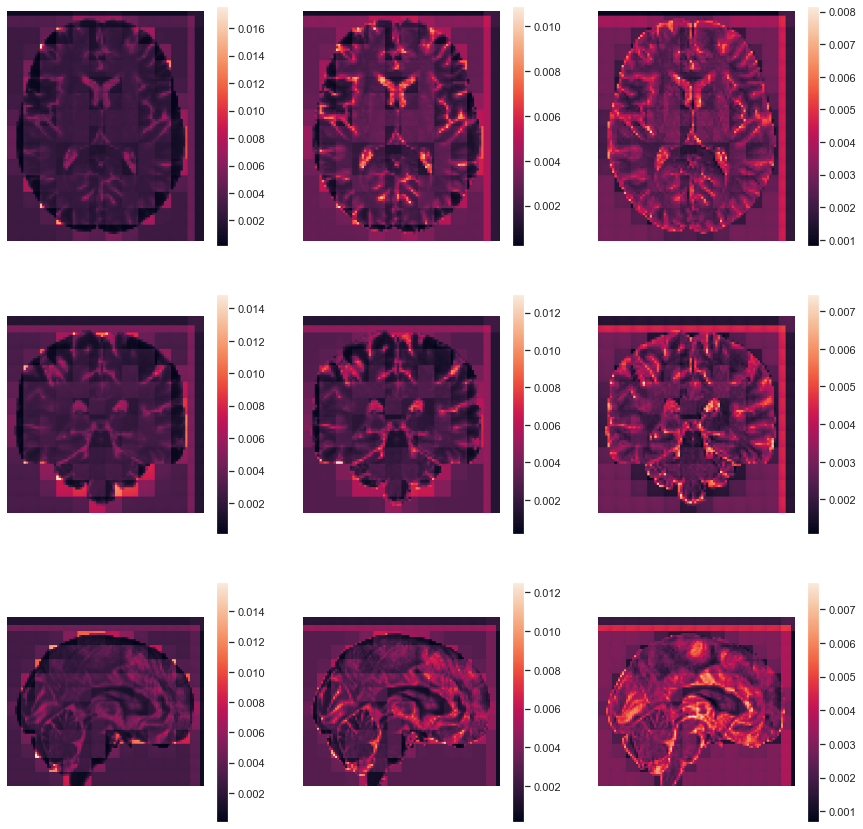

In [469]:
imgs = outUp.shape[0]
# vmin = outUp.numpy().min()
# vmax = outUp.numpy().max()
fig, axs = plt.subplots(imgs, imgs, figsize=(imgs*5, imgs*5))
axs = axs.flatten()
for idx in range(imgs*3):
    if idx < 3:
        im = axs[idx].imshow(ndimage.rotate(outUp[idx,:,:,80], 90))
    elif idx < 6:
        im = axs[idx].imshow(ndimage.rotate(outUp[idx-3,:,80,:], 90))
    else:
        im = axs[idx].imshow(ndimage.rotate(outUp[idx-6,80,:,:], 90))
        
    axs[idx].grid()
    axs[idx].axis('off');
    
    fig.colorbar(im, ax=axs[idx])
    
# cbar_ax = fig.add_axes([0.925, 0.15, 0.05, 0.7])
# fig.colorbar(im, cbar_ax)

In [582]:
idx = 1

msk = mask[idx]
mskQMean = msk.mean(axis=2) # mean across the querry axis
mskQMean = mskQMean.permute(1,0,2)
window_size = round(mskQMean.size(-1)**(1/3))

mskQMean = mskQMean.view(mskQMean.shape[0], mskQMean.shape[1], window_size, window_size, window_size)

n_windows_x = ceil(160/(7*2))
n_windows_y = ceil(192/(7*2))
n_windows_z = ceil(160/(7*2))

if idx / 2 >= 1:
    idxPower = floor(idx / 2)
    n_windows_x = ceil(n_windows_x/2**idxPower)
    n_windows_y = ceil(n_windows_y/2**idxPower)
    n_windows_z = ceil(n_windows_z/2**idxPower)

out = window_reverse(mskQMean, (7,7,7), 
                     dims=(mskQMean.shape[0], n_windows_x*7, n_windows_y*7, n_windows_z*7)).squeeze()

scale_factor = 2**(floor(idx / 2)+1)
upsample = Upsample(scale_factor=scale_factor)

outUp = upsample(torch.unsqueeze(out, 1)).squeeze()

## Due to shifted window, cannot use one single crop approach...
# pd = ConstantPad3d(10, 0)
# outUpCrop = pd(outUp)
# outUpCrop = outUpCrop[:,
#              4:164,
#              4:196,
#              4:164]
# outUpCropMean = torch.mean(outUpCrop, axis=0)
# outUpCropMax = torch.max(outUpCrop, axis=0)[0]

outUpCropMean = torch.mean(outUp, axis=0)
outUpCropMax = torch.max(outUp, axis=0)[0]

In [583]:
len(axs)

6

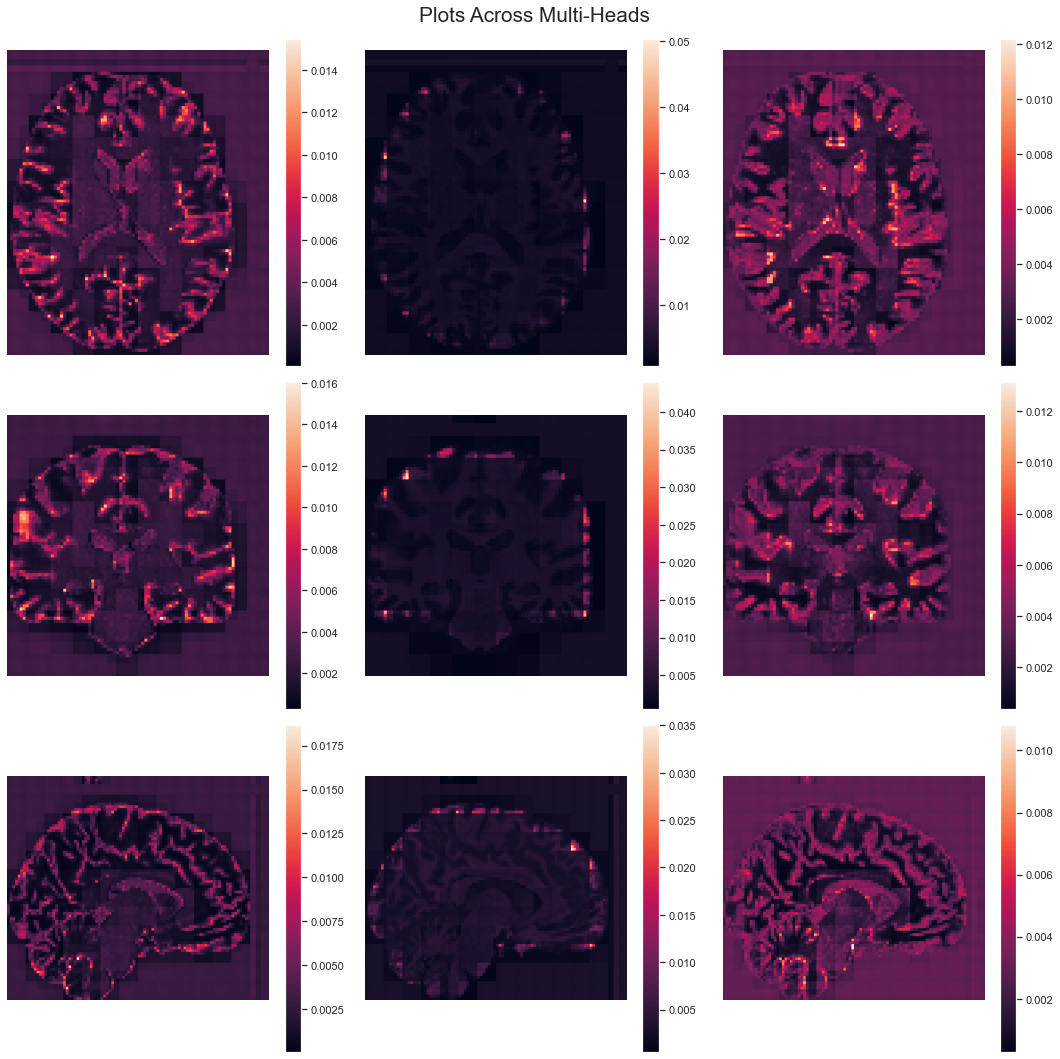

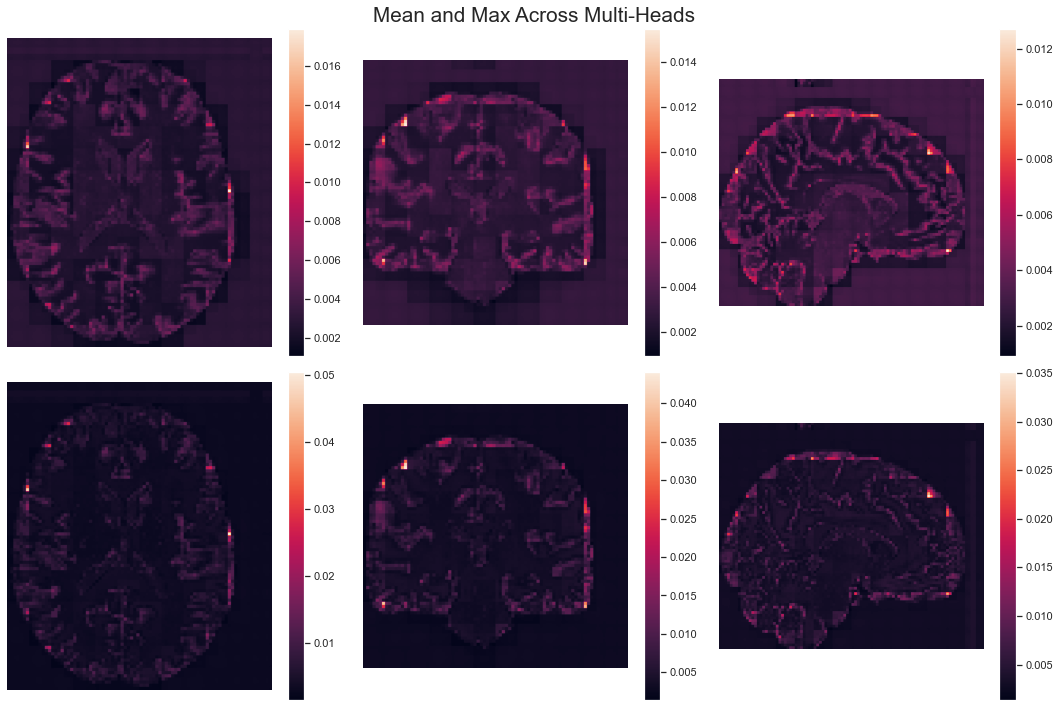

In [584]:
imgs = outUp.shape[0]
# vmin = outUp.numpy().min()
# vmax = outUp.numpy().max()
fig, axs = plt.subplots(3, imgs, figsize=(imgs*5, 3*5))
axs = axs.flatten()
for i in range(imgs*3):
    if i < imgs:
        im = axs[i].imshow(ndimage.rotate(outUp[i,:,:,80], 90))
    elif i < 2*imgs:
        im = axs[i].imshow(ndimage.rotate(outUp[i-2*imgs,:,80,:], 90))
    else:
        im = axs[i].imshow(ndimage.rotate(outUp[i-3*imgs,80,:,:], 90))
        
    axs[i].grid()
    axs[i].axis('off');
    
    fig.colorbar(im, ax=axs[i])
    
# cbar_ax = fig.add_axes([0.925, 0.15, 0.05, 0.7])
# fig.colorbar(im, cbar_ax)
fig.tight_layout()
st = fig.suptitle("Plots Across Multi-Heads", fontsize="xx-large")
# st.set_y(0.95)
fig.subplots_adjust(top=0.95)



fig, axs = plt.subplots(2,3, figsize=(15, 10))
axs = axs.flatten()
im = axs[0].imshow(ndimage.rotate(outUpCropMean[:,:,80], 90))
axs[0].grid()
axs[0].axis('off');
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(ndimage.rotate(outUpCropMean[:,80,:], 90))
axs[1].grid()
axs[1].axis('off');
fig.colorbar(im, ax=axs[1])
im = axs[2].imshow(ndimage.rotate(outUpCropMean[80,:,:], 90))
axs[2].grid()
axs[2].axis('off');
fig.colorbar(im, ax=axs[2])
im = axs[3].imshow(ndimage.rotate(outUpCropMax[:,:,80], 90))
axs[3].grid()
axs[3].axis('off');
fig.colorbar(im, ax=axs[3])
im = axs[4].imshow(ndimage.rotate(outUpCropMax[:,80,:], 90))
axs[4].grid()
axs[4].axis('off');
fig.colorbar(im, ax=axs[4])
im = axs[5].imshow(ndimage.rotate(outUpCropMax[80,:,:], 90))
axs[5].grid()
axs[5].axis('off');
fig.colorbar(im, ax=axs[5])
fig.tight_layout()

st = fig.suptitle("Mean and Max Across Multi-Heads", fontsize="xx-large")
# st.set_y(0.95)
fig.subplots_adjust(top=0.95)

In [ ]:
[i for i in range(3)]

In [ ]:
axs

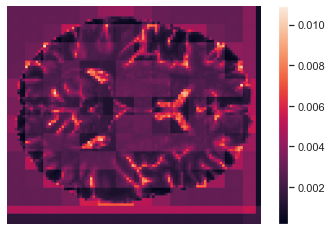

In [395]:
plt.imshow(outUp[1,:,:,80])
plt.grid()
plt.axis('off');
plt.colorbar()

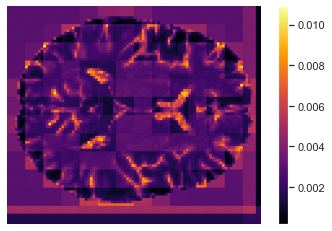

In [399]:
plt.imshow(outUp[1,:,:,80], cmap='inferno')
plt.grid()
plt.axis('off');
plt.colorbar()

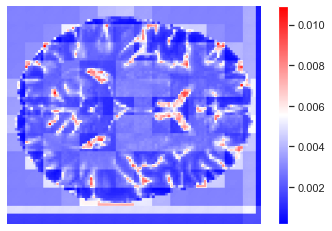

In [397]:
plt.imshow(outUp[1,:,:,80], cmap='bwr')
plt.grid()
plt.axis('off');
plt.colorbar()

In [387]:
outUp.numpy().max()

0.018169539

In [389]:
abs(outUp.numpy().min())

2.4334666e-05

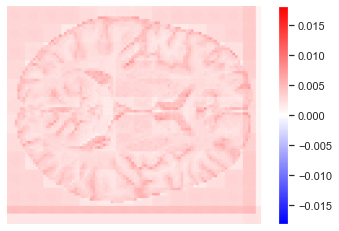

In [394]:
scalar = max(outUp.numpy().max(), abs(outUp.numpy().min()))

plt.imshow(outUp[2,:,:,80], vmin=-scalar, vmax=scalar, cmap='bwr')
plt.grid()
plt.axis('off');
plt.colorbar()

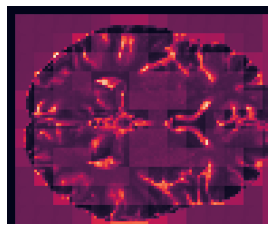

In [371]:
plt.imshow(outUpCrop[1,:,:,80])
plt.grid()
plt.axis('off');

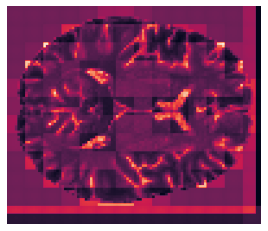

In [372]:
plt.imshow(outUpCropMean[:,:,80])
plt.grid()
plt.axis('off');

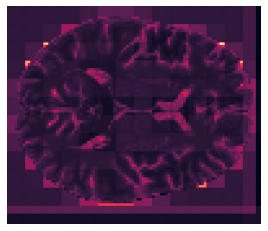

In [373]:
plt.imshow(outUpCropMax[:,:,80])
plt.grid()
plt.axis('off');

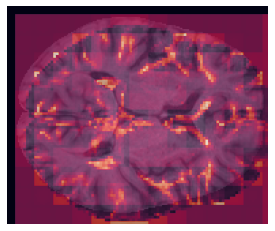

In [368]:
plt.imshow(Xviz[:,:,80], cmap='gray')
plt.imshow(outUpCropMean[:,:,80], alpha=0.75)
plt.grid()
plt.axis('off');

In [40]:
idx = 4

In [41]:
msk = mask[idx]

In [42]:
msk.shape

torch.Size([36, 12, 343, 343])

In [43]:
msk.permute(1, 0, 2, 3).shape

torch.Size([12, 36, 343, 343])

In [44]:
mskQMean = msk.mean(axis=2) # mean across the querry axis
mskQMean.shape

torch.Size([36, 12, 343])

In [45]:
mskQMean = mskQMean.permute(1,0,2)

In [46]:
# attn_windows = attn_windows.view(-1, *(window_size + (c,)))

In [47]:
window_size = round(mskQMean.size(-1)**(1/3))
mskQMean = mskQMean.view(mskQMean.shape[0], mskQMean.shape[1], window_size, window_size, window_size)

In [48]:
from SwinAgeMapper import window_reverse
from math import ceil, floor

In [49]:
mskQMean.shape

torch.Size([12, 36, 7, 7, 7])

In [50]:
ceil(192/(7*2**2))

7

In [51]:
n_windows_x = ceil(160/(7*2))
n_windows_y = ceil(192/(7*2))
n_windows_z = ceil(160/(7*2))

if idx / 2 >= 1:
    idxPower = floor(idx / 2)
    n_windows_x = ceil(n_windows_x/2**idxPower)
    n_windows_y = ceil(n_windows_y/2**idxPower)
    n_windows_z = ceil(n_windows_z/2**idxPower)
    print('y')

y


In [52]:
print(n_windows_x, n_windows_y, n_windows_z)

3 4 3


In [53]:
dims = (mskQMean.shape[0], n_windows_x*7, n_windows_y*7, n_windows_z*7)
dims

(12, 21, 28, 21)

In [54]:
out = window_reverse(mskQMean, (7,7,7), 
                     dims=(mskQMean.shape[0], n_windows_x*7, n_windows_y*7, n_windows_z*7)).squeeze()

In [55]:
out.shape

torch.Size([12, 21, 28, 21])

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

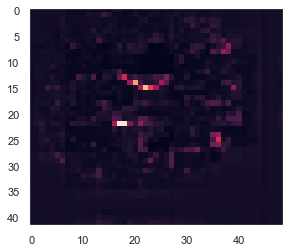

In [354]:
plt.imshow(out[5,:,:,21])
plt.grid()

In [355]:
from torch.nn import Upsample

In [356]:
scale_factor = 2**(floor(idx / 2)+1)
upsample = Upsample(scale_factor=scale_factor)

In [357]:
outUp = upsample(torch.unsqueeze(out, 1)).squeeze()
outUp.shape

torch.Size([6, 168, 196, 168])

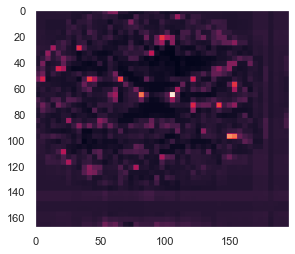

In [358]:
plt.imshow(outUp[5,:,:,82])
plt.grid()
plt.imsave('test_attn_drop.png', outUp[1,:,:,80])

In [359]:
outUp.shape

torch.Size([6, 168, 196, 168])

In [360]:
outUpCrop = outUp[:,
             0:160,
             0:192,
             0:160]

In [361]:
import torch.nn.functional as F
import torch.nn as nn

torch.Size([6, 188, 216, 188])
1 torch.Size([6, 160, 192, 160])
(160, 192, 160)


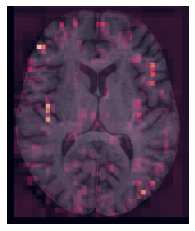

In [362]:
pd = nn.ConstantPad3d(10, 0)

outUpCrop = pd(outUp)
print(outUpCrop.shape)
outUpCrop = outUpCrop[:,
             4:164,
             4:196,
             4:164]

# outUpCrop = outUp[:,
#              0:168,
#              0:196,
#              0:168]

print('1',outUpCrop.shape)
print(Xviz.shape)

# plt.imshow(Xviz[:,:,80], cmap='gray')
# # plt.imshow(outUp[2,:,:,80], alpha=0.7)
# plt.imshow(outUpCrop[2,:,:,80], alpha=0.75)

# plt.imshow(ndimage.rotate(Xviz[80,:,:], 90), cmap='gray')
# # plt.imshow(outUp[2,:,:,80], alpha=0.7)
# plt.imshow(ndimage.rotate(outUpCrop[2,80,:,:], 90), alpha=0.7)

# plt.imshow(ndimage.rotate(Xviz[:,100,:], 90), cmap='gray')
# # plt.imshow(outUp[2,:,:,80], alpha=0.7)
# plt.imshow(ndimage.rotate(outUpCrop[2,:,100,:], 90), alpha=0.7)

plt.imshow(ndimage.rotate(Xviz[:,:,80], 90), cmap='gray')
# plt.imshow(outUp[2,:,:,80], alpha=0.7)
plt.imshow(ndimage.rotate(outUpCrop[3,:,:,80], 90), alpha=0.7)

plt.grid()
plt.axis('off');


# ndimage.rotate(X[:,:,80], 90)

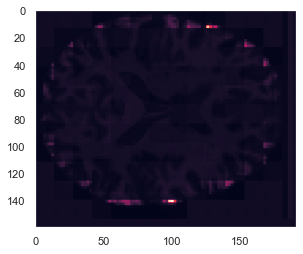

In [53]:
plt.imshow(outUpCrop[1,:,:,82])
plt.grid()
plt.imsave('test_attn_drop.png', outUp[1,:,:,80])

In [54]:
outUpCrop.shape

torch.Size([3, 160, 192, 160])

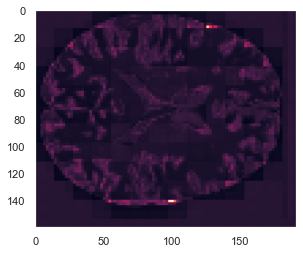

In [55]:
outUpCropMean = torch.mean(outUpCrop, axis=0)
plt.imshow(outUpCropMean[:,:,82])
plt.grid()
plt.imsave('test_attn_drop_avg.png', outUpCropMean[:,:,82])

In [56]:
outUpCropMax = torch.max(outUpCrop, axis=0)[0]

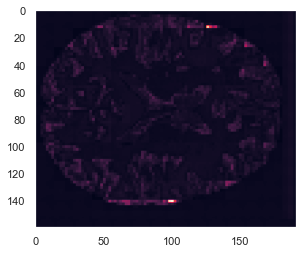

In [57]:
plt.imshow(outUpCropMax[:,:,82])
plt.grid()
plt.imsave('test_attn_drop_max.png', outUpCropMax[:,:,82])